# Model efficacy comparison

This script just does some quick analysis comparing our model output to the actual captions.

**Get output**: First, we import the files that Owais used.

In [114]:
import pandas as pd

df_New = pd.read_csv('output.txt').rename(columns={"tags": "30k_tags"})
df_Old = pd.read_csv('output8kOldModel.txt').rename(columns={"tags": "8k_tags"})

df_Gen = df_New.merge(df_Old, on="image")

,image,30k_tags,8k_tags
0,COCO_val2014_000000000042.jpg,dog man holding are,air holding baby man is
1,COCO_val2014_000000000073.jpg,young man are playing,red riding man bike helmet is shirt
2,COCO_val2014_000000000074.jpg,bicycle man walks,ball red playing children are grass
3,COCO_val2014_000000000133.jpg,man floor holding,red ball red boy playing is young shirt
4,COCO_val2014_000000000136.jpg,dog white man holding,red man sitting bench is shirt
...,...,...,...
95,COCO_val2014_000000001244.jpg,water man fhing,people water dock are sitting overlooking
96,COCO_val2014_000000001268.jpg,water man people are,front people water are sitting bench
97,COCO_val2014_000000001270.jpg,player ball,field playing are men baseball
98,COCO_val2014_000000001290.jpg,holding woman newborn sitting young man,are sitting bed girls


**Bring the full caption file in**: Build 2 dataframe: 1) image names and ids 2) image captions and ids

In [54]:
import json

with open('expected.json') as f:
    data = json.load(f)

image_data = {}  

# go through the image data
for im_data in data["images"]:
    image_data[im_data['id']] = im_data['file_name']

annot_data = {}
for an in data["annotations"]:
    im_id = an["image_id"]
    caption = an["caption"]
    
    # if the id is in the image_data dict and not already in this one, add it
    if ((im_id in image_data.keys()) and (im_id not in annot_data.keys())):
        annot_data[im_id] = caption

In [97]:
im_df = pd.DataFrame.from_dict(data = image_data, orient = 'index', columns=["filename"])
an_df = pd.DataFrame.from_dict(data = annot_data, orient = 'index', columns=["caption"])

# join the image and caption df
joined = im_df.join(an_df)

# trim the full imageset to only the ones that Owais has used
expected = joined[joined["filename"].isin(df_New["image"])]

**Aux function:** This function is used to get the flickr url

In [124]:
filename = "COCO_val2014_000000000764.jpg"
# go through the image data
for im_data in data["images"]:
    if im_data['file_name'] == filename:
        print(im_data['flickr_url'])

http://farm4.staticflickr.com/3042/2382587978_e8db136faf_z.jpg


**Extract tokens:** This function is used to extract the necessary tokens from the captions

In [79]:
# function that creates tokens
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def extract_tokens(captions):
    # Extract specific tokens from each caption
    extracted_tokens = []
    for caption in captions:
        # Tokenize the caption
        tokens = word_tokenize(caption)

        # Tag each token with its part of speech
        tagged_tokens = pos_tag(tokens)

        # Extract specific tokens based on their part of speech
        nouns = [token[0] for token in tagged_tokens if token[1].startswith("N")]
        verbs = [token[0] for token in tagged_tokens if token[1].startswith("V")]
        adjectives = [token[0] for token in tagged_tokens if token[1].startswith("J")]

        # Combine extracted tokens into meaningful phrases
        noun_phrases = []
        current_phrase = []
        for token in tagged_tokens:
            if token[1].startswith("N"):
                current_phrase.append(token[0])
            elif current_phrase:
                # Combine consecutive nouns into noun phrases
                noun_phrases.append(" ".join(current_phrase))
                current_phrase = []
        if current_phrase:
            noun_phrases.append(" ".join(current_phrase))

        verb_phrases = verbs

        adjective_phrases = []
        current_phrase = []
        for token in tagged_tokens:
            if token[1].startswith("J"):
                current_phrase.append(token[0])
            elif current_phrase:
                # Combine consecutive adjectives into adjective phrases
                adjective_phrases.append(" ".join(current_phrase))
                current_phrase = []
        if current_phrase:
            adjective_phrases.append(" ".join(current_phrase))

        # Combine all extracted phrases into a single list of tokens
        extracted_tokens.append(list(set(noun_phrases + verbs + adjective_phrases)))
        
    return extracted_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rubin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rubin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [109]:
extracted = extract_tokens(final_expected["caption"].values.tolist())
extracted_str = [" ".join(x) for x in extracted]
expected["expected_tags"] = extracted_str

exp = expected.drop(['caption'], axis=1).rename(columns={"filename" : "image"})

C:\Users\Rubin\AppData\Local\Temp\ipykernel_11628\4168272363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expected["expected_tags"] = extracted_str


**Join the expected tags with the generated ones**

In [126]:
final = exp.merge(df_Gen, on="image")
final

,image,expected_tags,30k_tags,8k_tags
0,COCO_val2014_000000001146.jpg,man smiling wearing flowered standing is young...,hand man holding,front standing man is store black shirt
1,COCO_val2014_000000000400.jpg,inside sitting dog boat white,water man children are,jacket man sitting bench is black
2,COCO_val2014_000000000764.jpg,people playing frisbee image,holding shirt white are blue girl man,field playing are men soccer
3,COCO_val2014_000000000459.jpg,man holding shoulder left camera,man people holding are,front standing man is store black shirt
4,COCO_val2014_000000000715.jpg,bananas oranges pile yellow crates topped,sitting woman man are,front standing man is camera black shirt
...,...,...,...,...
95,COCO_val2014_000000000623.jpg,bench giant teddy bear hugging is woman,man woman holding girl,toy playing children are
96,COCO_val2014_000000000474.jpg,boy grass field ready catch young baseball get...,playing shirt blue man field,red ball red playing boy is shirt
97,COCO_val2014_000000000632.jpg,comforter blue bookcase window Bedroom scene,sitting are woman couch,running grass is dog
98,COCO_val2014_000000000536.jpg,talking dresses women phone,woman are sitting young man,women are sitting bench


# Perform Analyses

Now that we have the data, we can perform the similarity comparison between the different cols

In [132]:
from fuzzywuzzy import fuzz

expected_tags = final["expected_tags"].values.tolist()
tags_30k = final["30k_tags"].values.tolist()
tags_8k = final["8k_tags"].values.tolist()

exp_30K = []
exp_8K = []

for i in range(len(expected_tags)):
    fuzz_30 = fuzz.token_sort_ratio(expected_tags[i], tags_30k[i])/100
    fuzz_8 = fuzz.token_sort_ratio(expected_tags[i], tags_8k[i])/100
    exp_30K.append(fuzz_30)
    exp_8K.append(fuzz_8)

final["Fuzzy 30K"] = exp_30K
final["Fuzzy 8K"] = exp_8K


,image,expected_tags,30k_tags,8k_tags,Fuzzy 30K,Fuzzy 8K
0,COCO_val2014_000000001146.jpg,man smiling wearing flowered standing is young...,hand man holding,front standing man is store black shirt,0.28,0.59
1,COCO_val2014_000000000400.jpg,inside sitting dog boat white,water man children are,jacket man sitting bench is black,0.43,0.45
2,COCO_val2014_000000000764.jpg,people playing frisbee image,holding shirt white are blue girl man,field playing are men soccer,0.34,0.54
3,COCO_val2014_000000000459.jpg,man holding shoulder left camera,man people holding are,front standing man is store black shirt,0.67,0.39
4,COCO_val2014_000000000715.jpg,bananas oranges pile yellow crates topped,sitting woman man are,front standing man is camera black shirt,0.35,0.40
...,...,...,...,...,...,...
95,COCO_val2014_000000000623.jpg,bench giant teddy bear hugging is woman,man woman holding girl,toy playing children are,0.46,0.44
96,COCO_val2014_000000000474.jpg,boy grass field ready catch young baseball get...,playing shirt blue man field,red ball red playing boy is shirt,0.38,0.51
97,COCO_val2014_000000000632.jpg,comforter blue bookcase window Bedroom scene,sitting are woman couch,running grass is dog,0.33,0.31
98,COCO_val2014_000000000536.jpg,talking dresses women phone,woman are sitting young man,women are sitting bench,0.52,0.60


**Plot histogram to see distribution of fuzzy ratios**

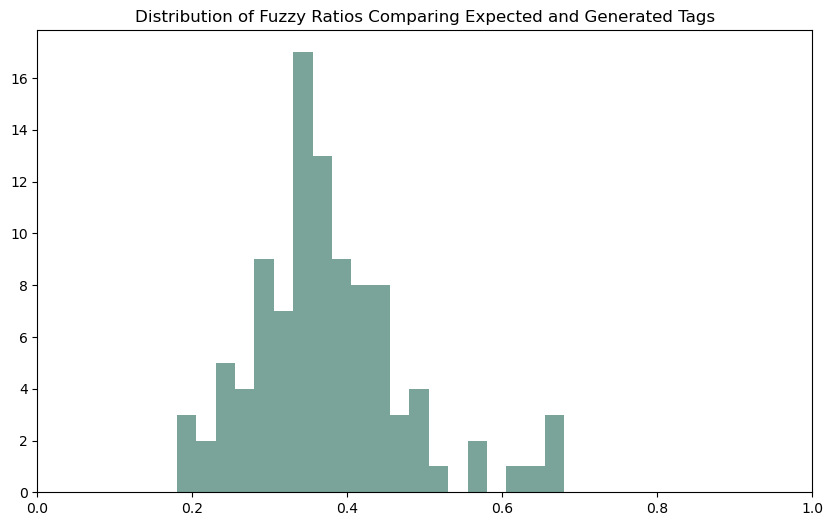

In [157]:
import matplotlib.pyplot as plt

bins = 20

plt.figure(figsize=(10,6))
plt.hist(final["Fuzzy 30K"].values.tolist(), bins=bins, color="#7aa39a")
plt.xlim([0.0, 1])
plt.title("Distribution of Fuzzy Ratios Comparing Expected and Generated Tags")
plt.show()